In [12]:
"""Imports"""
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.layers import Dense, Dropout, LSTM, Activation, Input
from keras.models import Sequential
from keras.utils import pad_sequences
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split


# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
"""Load up the benzene data"""
path_to_file = Path(Path.cwd().parents[1], "Data", "Benzene.csv")
benzene = pd.read_csv(path_to_file)

benzene.head()

,Date,Time,C6H6(GT),PT08.S5(O3),Temperature (C),Relative Humidity,Absolute Humidity,Datetime
0,2004-03-10,18:00:00,0.18553,0.45482,0.33333,0.49937,0.28007,2004-03-10 18:00:00
1,2004-03-10,19:00:00,0.14623,0.32624,0.32688,0.48428,0.26428,2004-03-10 19:00:00
2,2004-03-10,20:00:00,0.13994,0.37055,0.29677,0.56352,0.27635,2004-03-10 20:00:00
3,2004-03-10,21:00:00,0.14308,0.42659,0.27742,0.63899,0.29419,2004-03-10 21:00:00
4,2004-03-10,22:00:00,0.10063,0.38619,0.28172,0.63396,0.29522,2004-03-10 22:00:00


# Linear Regression

In [ ]:
"""Helper functions"""
def plot_lr_data(mu, prediction_horizon, number_of_samples, tp_pred, yp_pred, time_series, sensor_values, first=True):
	fig, ax = plt.subplots(figsize=(10,10))
	fig.suptitle(f"{['Last', 'First'][first]} 200 Sensor Output Prediction", fontsize=22, fontweight='bold')
	ax.set_title(f"mu = {mu}, ph = {prediction_horizon / 3600} hours")

	if first:
		ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
		ax.plot(time_series.iloc[0:200,0], sensor_values.iloc[0:200,0], label='Sensor Readings')
	else:
		ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
		ax.plot(time_series.iloc[number_of_samples-200:number_of_samples:,0],
		  sensor_values.iloc[number_of_samples-200:number_of_samples:,0], label='Sensor Readings')

	ax.set_xlabel("time (epoch)")
	ax.set_ylabel("normalized output")
	ax.legend()

	plt.show()

In [4]:
"""convert datetime to epoch/unix time and add as new column"""
benzene["Datetime"] = pd.to_datetime(benzene["Datetime"])
benzene["unix"] = benzene["Datetime"].apply(lambda x: x.timestamp())

benzene.head()

,Date,Time,C6H6(GT),PT08.S5(O3),Temperature (C),Relative Humidity,Absolute Humidity,Datetime,unix
0,2004-03-10,18:00:00,0.18553,0.45482,0.33333,0.49937,0.28007,2004-03-10 18:00:00,1078941600.00000
1,2004-03-10,19:00:00,0.14623,0.32624,0.32688,0.48428,0.26428,2004-03-10 19:00:00,1078945200.00000
2,2004-03-10,20:00:00,0.13994,0.37055,0.29677,0.56352,0.27635,2004-03-10 20:00:00,1078948800.00000
3,2004-03-10,21:00:00,0.14308,0.42659,0.27742,0.63899,0.29419,2004-03-10 21:00:00,1078952400.00000
4,2004-03-10,22:00:00,0.10063,0.38619,0.28172,0.63396,0.29522,2004-03-10 22:00:00,1078956000.00000


In [5]:
"""Setup data and train linear regression model to use as baseline"""
time_series = pd.DataFrame(benzene.unix)
sensor_values = pd.DataFrame(benzene.filter(["PT08.S5(O3)"]))

number_of_samples = len(time_series)
prediction_horizon = 24 * 3600
mu = 0.9

tp_pred = np.zeros(number_of_samples - 1)
yp_pred = np.zeros(number_of_samples - 1)

for i in range(2, number_of_samples + 1):
    ts_tmp = time_series[0:i]
    ys_tmp = sensor_values[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = weights[k] ** k
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    tp = time_series.iloc[i-1, 0] + prediction_horizon
    yp = m_tmp * tp + q_tmp

    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp.item()

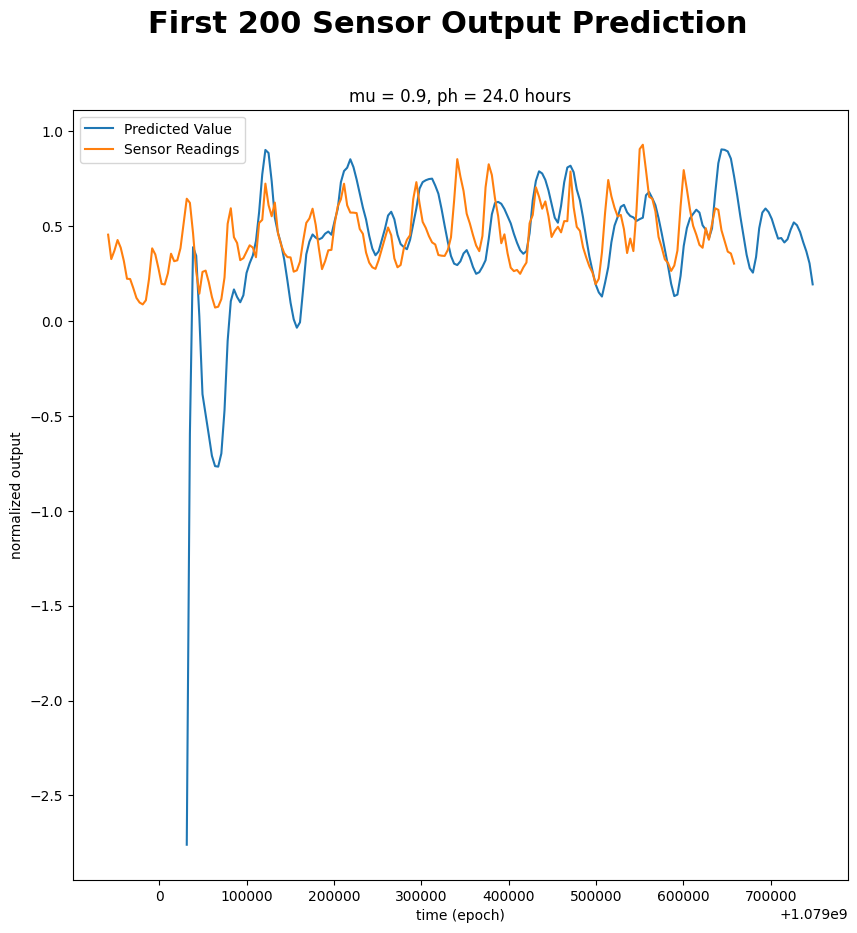

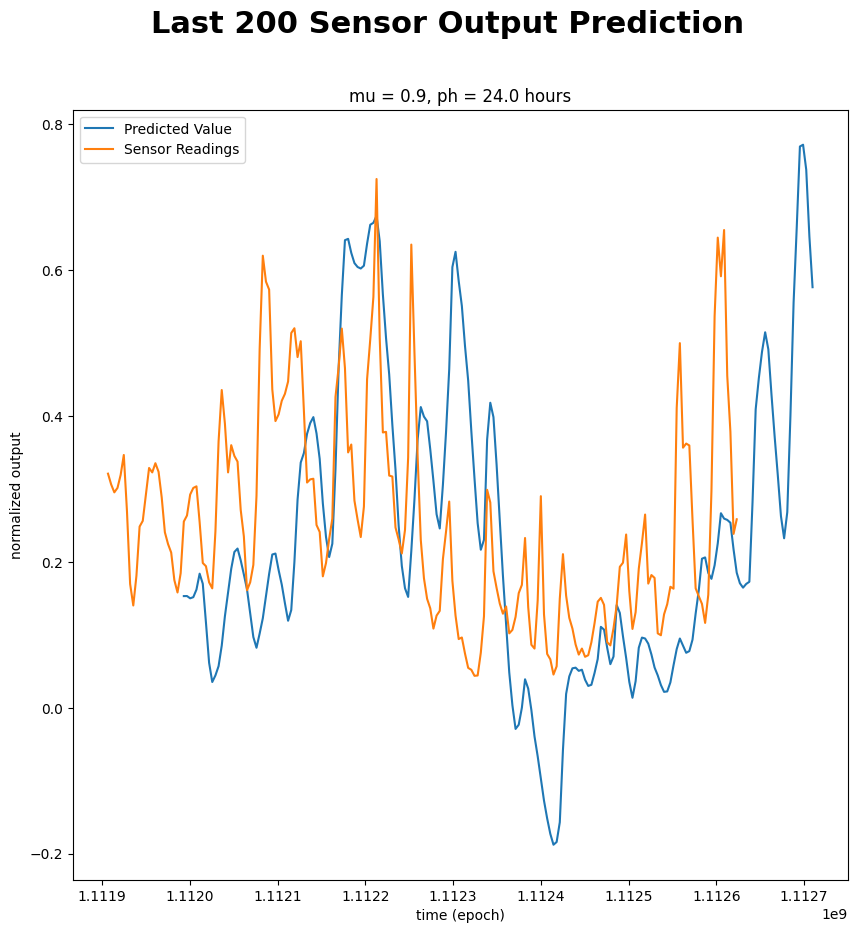

MSE is 0.018148589512320942


In [6]:
"""Visualize linear regression data"""
plot_lr_data(mu, prediction_horizon, number_of_samples, tp_pred, yp_pred, time_series, sensor_values, first=True)
plot_lr_data(mu, prediction_horizon, number_of_samples, tp_pred, yp_pred, time_series, sensor_values, first=False)
print("MSE is", mse(sensor_values["PT08.S5(O3)"][:-1], yp_pred))

- Predictions need to have a floor of 0 as a negative value is infeasible
- Need to convert from normalized back to ppm

In [7]:
"""Test different combos of variables"""
for column in ["Temperature (C)", "Relative Humidity", "Absolute Humidity"]:
	explanatories = pd.DataFrame({
	"epoch": benzene["unix"],
	"test": benzene[column]
	})

	tp2_pred = np.zeros(number_of_samples - 1)
	yp2_pred = np.zeros(number_of_samples - 1)

	for i in range(2, number_of_samples + 1):
		ts_tmp = explanatories[0:i]
		ys_tmp = sensor_values[0:i]
		ns = len(ys_tmp)

		weights = np.ones(ns) * mu
		for k in range(ns):
			weights[k] = weights[k] ** k
		weights = np.flip(weights, 0)

		lm_tmp = LinearRegression() 
		model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

		m_tmp = model_tmp.coef_
		q_tmp = model_tmp.intercept_

		time = explanatories.iloc[i-1, explanatories.columns.get_loc("epoch")] + prediction_horizon
		temp = explanatories.iloc[i-1, explanatories.columns.get_loc("test")]
		prediction = np.dot(m_tmp, np.array([time, temp])) + q_tmp

		tp2_pred[i-2] = time    
		yp2_pred[i-2] = prediction.item()

	print(f"MSE when using {column} is", mse(sensor_values["PT08.S5(O3)"][:-1], yp2_pred))

MSE when using Temperature (C) is 0.02216314269085993
MSE when using Relative Humidity is 0.02166899659905389
MSE when using Absolute Humidity is 0.02503436900628338


The MSE is worse than the base model for all attempts to use a secondary explanatory variable.

# LSTM

In [95]:
"""Helper functions"""
def plot_loss(history):
	fig_acc = plt.figure(figsize=(10, 10))
	plt.title("model loss/MSE")
	plt.ylabel("loss")
	plt.xlabel("epoch")

	plt.plot(history.history["loss"])
	plt.plot(history.history["val_loss"])

	plt.legend(["train", "test"], loc="upper left")
	plt.show()
	
	return fig_acc

def plot_predictions(predictions, truth):
	fig_verify = plt.figure(figsize=(10, 5))
	plt.title("O3 levels - Last 200 Points", fontsize=22, fontweight="bold")
	plt.ylabel("value")
	plt.xlabel("row")
	
	plt.plot(predictions[-200:], label = "Predicted Value")
	plt.plot(truth[-200:], label = "Actual Value")
	
	plt.legend()
	plt.show()

	return fig_verify

In [8]:
"""load in sensor data and split it for training and testing"""
sensor_data = benzene.filter(["PT08.S5(O3)"])

train, validate = train_test_split(sensor_data, train_size=0.8, random_state=73, shuffle=False)

training_data = train.reset_index(drop=True)
validation_data = validate.reset_index(drop=True)

assert len(training_data) + len(validation_data) == len(sensor_data)

print(f"Training data percentage: {round(len(training_data)/len(sensor_data), 2) * 100}%")

Training data percentage: 80.0%


In [ ]:
"""We'll start out with a 7 day input sequence and a 24 hour predictive horizon"""
seq_length = 7 * 24
ph = 24
feat_cols = ["PT08.S5(O3)"]

seq_arrays = (
    np.array([training_data[i:i + seq_length] for i in range(len(training_data) - seq_length - ph)], dtype = object)
    .astype(np.float32)
)
seq_labs = (
    np.array([training_data.iloc[i + ph] for i in range(seq_length, len(training_data) - ph)], dtype = object)
    .astype(np.float32)
    .ravel()
)

assert(seq_arrays.shape == (len(training_data) - seq_length - ph, seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(training_data) - seq_length - ph,))

seq_arrays.shape

(7293, 168, 1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 168, 5)         │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 168, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
14/14 - 2s - 171ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 2/100
14/14 - 1s - 50ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 3/100
14/14 - 1s - 50ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 4/100
14/14 - 1s - 49ms/step - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 5/100
14/14 - 1s - 49ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 6/100
14/14 - 1s - 49ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 7/100
14/14 - 1s - 49ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 8/100
14/14 - 1s - 51ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 9/100
14/14 - 1s - 50ms/step - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 10/100
14/14 - 1s - 49ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 0.0325 -

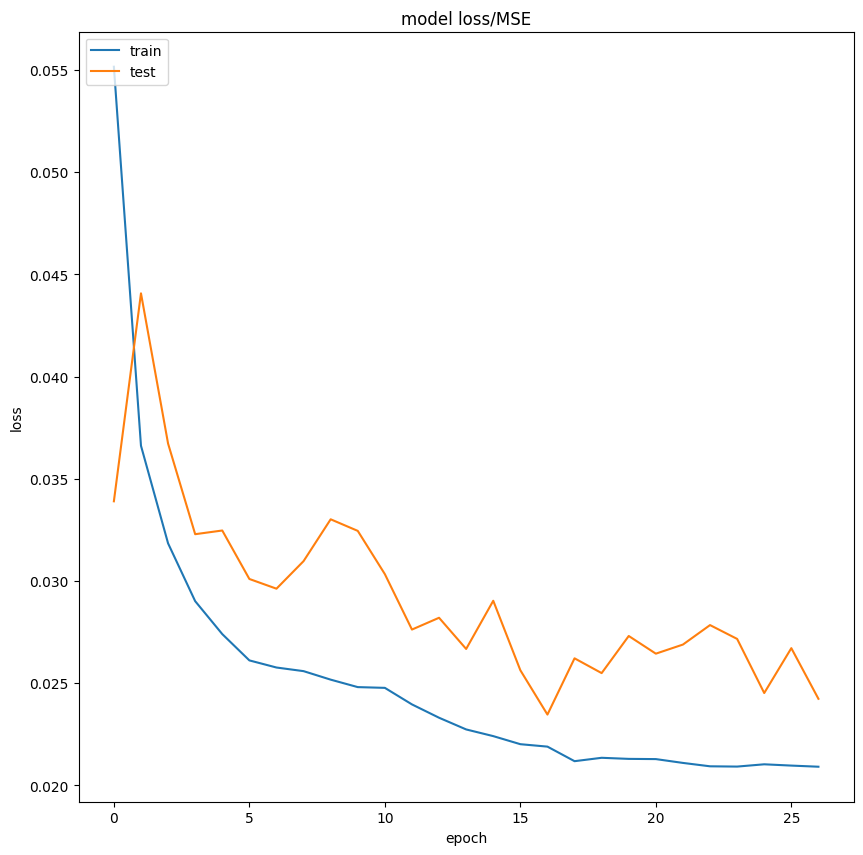

In [ ]:
"""Layout Baseline architecture to use as comparision in future"""
model_path = "LSTM_baseline.keras"

nb_features = 1
nb_out = 1

model = Sequential()
model.add(Input(shape=(seq_length, nb_features)))
model.add(LSTM(units=5, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=3,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation(keras.activations.relu))

optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mse"])
print(model.summary())

history = model.fit(
    seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=0, mode="min")]
            #    keras.callbacks.ModelCheckpoint(model_path, monitor="val_loss", save_best_only=True, mode="min", verbose=0)]
    )
print(history.history.keys())

loss_figure = plot_loss(history)
# figure.savefig(model_path.split(".")[0]+".png")

In [ ]:
"""Create our validation sequence with a minimum number of records left padded with zeros"""
MIN_COUNT = 2

val_arrays = (
    np.array(pad_sequences([
    	validation_data[max(0, i): i + seq_length].values
    	for i in range(MIN_COUNT - seq_length, len(validation_data) - seq_length - ph)
		], dtype="float32"))
    .astype(np.float32)
)
val_labs = (
    np.array(
        [validation_data.iloc[i + ph] for i in range(MIN_COUNT, len(validation_data) - ph)])
    .astype(np.float32)
    .ravel()
)

assert(val_arrays.shape == (len(validation_data) - ph - MIN_COUNT, seq_length, len(feat_cols)))
assert(val_labs.shape == (len(validation_data) - ph - MIN_COUNT,))

val_arrays.shape

(1846, 168, 1)

58/58 - 0s - 8ms/step - loss: 0.0285 - mse: 0.0285
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


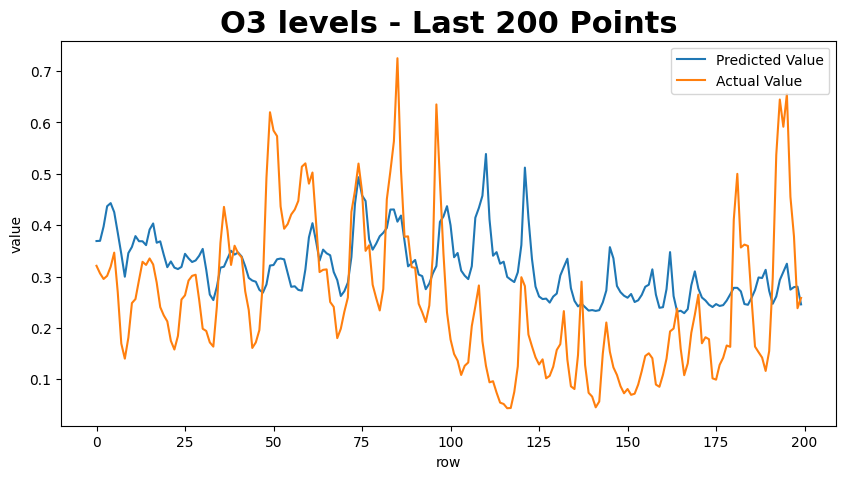


MSE: 0.0285125020891428


In [ ]:
"""Score our baseline model and visualize it's predictions"""
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
predictions = model.predict(val_arrays)

predictions_figure = plot_predictions(predictions, val_labs)
print("\nMSE: {}".format(scores_test[1]))

Looks like there is quite some room for improvement

In [ ]:
"""Tune the hyperparameters to see what we can get"""